Requirements to run:

torch, matplotlib, opencv-python, tqdm, numpy

train_sims.npy, val_sims.npy, test_sims.npy (You may need to change the paths)

the unet file, or replace the import with code from previous notebooks

Data in 200x200 format with conductivity, pressure, and porosity. (Again, you may need to change path)

At the bottom in the evaluation section, there are some pre-named models. You should replace these with the names of your saved models.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
from unet import *

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Required functions and constants

test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 250]

# Folders
BINARY_FOLDER = "../Data200x200_withinfo"
UNIFORM_FOLDER = "../Uniform200x200withInfo"

# Get porosity phi
def get_phi(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step,folder):
    return cv2.imread(f"{folder}/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step,folder):
    return np.array((get_k(sim,step,folder), get_pres(sim,step,folder), get_phi(sim,step,folder)), dtype=np.float32)

# Darcy loss function
def darcy_loss(model, inp):

    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

First define what dataset you want to test on

In [3]:
# Testing Dataset, assuming uniform sensor points
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 points_per_side = 3,
                 radius = 5,
                 steps = 200,
                 H=200,
                 W=200,
                 channels="all"):
        
        self.sims = sims
        self.n_sims = sims.shape[0]
        self.points_per_side = points_per_side
        self.steps = steps
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels

        div = (points_per_side + 1)

        self.point_x = np.arange(200 // div, 200, 200 // div)
        self.point_y = np.arange(200 // div, 200, 200 // div)

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    def __getitem__(self, index):

        if index >= self.sims.shape[0] * self.steps:
            index = index - self.sims.shape[0] * self.steps
            kind = 1
        else:
            kind = 0

        if kind == 0:
            folder = BINARY_FOLDER
        else:
            folder = UNIFORM_FOLDER

        sim_idx = (index // self.steps) % self.n_sims
        sim_step = index % self.steps

        # Create tensor for the target
        t = torch.tensor(get_all(self.sims[sim_idx], sim_step + 1, folder))

        # Create 0-matrix
        z = torch.zeros_like(t)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
        for y0 in self.point_y:
            for x0 in self.point_x:
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk

        # write revealed pixels for selected channels
        chans = self._chan_idx()
        z[chans, :, :] = torch.where(mask, t[chans, :, :], torch.zeros_like(t[chans, :, :]))

        return z,t
    
    def __len__(self):
        return self.sims.shape[0] * self.steps * 2

In [4]:
def loss_matrix_2(dataset, model):
    mse = nn.MSELoss()

    with torch.inference_mode():

        losses = torch.zeros((2, test_sims.shape[0], 200), dtype=torch.float16)
        k_losses = torch.zeros((2, test_sims.shape[0], 200), dtype=torch.float16)
        pres_losses = torch.zeros((2, test_sims.shape[0], 200), dtype=torch.float16)
        darcy_losses = torch.zeros((2, test_sims.shape[0], 200), dtype=torch.float16)

        for t in tqdm(range(2)):
            for sim in tqdm(range(test_sims.shape[0])):
                for step in range(200):

                    feat, label = dataset.__getitem__(t * test_sims.shape[0] * 200 + sim * 200 + step)
                    feat, label = feat.to(device).unsqueeze(0), label.to(device).unsqueeze(0)
                    p_loss, out = darcy_loss(model, feat)
                    darcy_losses[t, sim, step] = p_loss
                    mse_loss = mse(out, label)
                    losses[t, sim, step] = mse_loss
                    k_loss = mse(out[:,0], label[:,0])
                    pres_loss = mse(out[:,1], label[:,1])
                    k_losses[t, sim, step] = k_loss
                    pres_losses[t, sim, step] = pres_loss

        return darcy_losses, losses, k_losses, pres_losses

In [5]:
# Define functions for inference
def loss_matrix(loader, model):

    mse = nn.MSELoss(reduction='none')

    with torch.inference_mode():

        losses = torch.tensor([], dtype=torch.float16, device='cuda')
        darcy_losses = torch.tensor([], dtype=torch.float16, device='cuda')

        for feat,label in tqdm(loader):
            feat = feat.to(device)
            label = label.to(device)

            p_loss, out = darcy_loss(model, feat)

            darcy_losses = torch.cat((darcy_losses, p_loss))
            mse_loss = mse(out, label)
            losses = torch.cat((losses, mse_loss))

    return darcy_losses, mse_loss

In [6]:
dataset = MaskedDataset(test_sims, 3)
loader = torch.utils.data.DataLoader(dataset, batch_size= 8, shuffle=False)

In [ ]:
model = torch.load("./small_data_mixed/first150steps_mixed_disk_fixedpoint_e450.pt", weights_only=False).to(device)

In [8]:
d,m,k,p = loss_matrix_2(dataset, model)

100%|██████████| 2/2 [05:06<00:00, 153.39s/it]


In [ ]:
torch.save(m, "./results/mse_150step_3fixed.pt")
torch.save(d, "./results/darcy_150step_3fixed.pt")
torch.save(k, "./results/conductivity_150step_3fixed.pt")
torch.save(p, "./results/pressure_150step_3fixed.pt")

In [12]:
m = m.cpu().detach().numpy()
d = d.cpu().detach().numpy()
k = k.cpu().detach().numpy()
p = p.cpu().detach().numpy()

[]

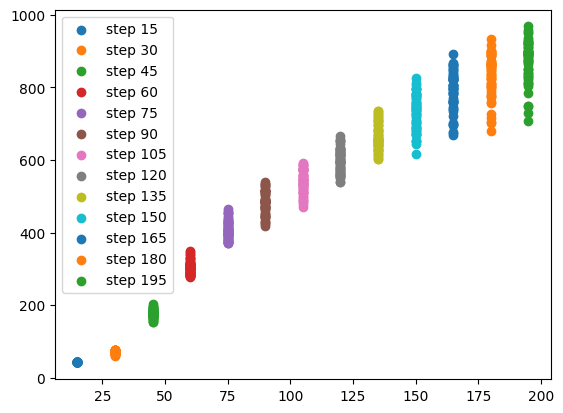

In [14]:
for step in range(15,200,15):
    plt.scatter([step for i in range(1,test_sims.shape[0])], k[0, 1:, step], label=f"step {step}")
plt.legend()
plt.plot()

In [ ]:
for step in range(15,200,15):
    plt.scatter([step for i in range(1,test_sims.shape[0])], m[0, 1:, step], label=f"step {step}")
plt.legend()
plt.plot()